This document describes the bid and response stratgies for various device types in TESS.

#### Revision history

| Date        | Author           | Remarks
| ----------- | ---------------- | -------
| 11 Mar 2020 | David P. Chassin | Initial draft

# Price Response

Bid/response strategies require information from the market about future prices. The required values are denoted, $P_{exp}$ and $P_{dev}$, the expected price and the expected standard deviation, respectively, for the upcoming market interval. 

The ideal market interval, $t_s$, is based on the natural time-constant of the fastest acting device.   A good rule of thumb to determine the market interval is to sample the states at about 10 times the fastest acting device's time constant. In homes, HVAC systems typically have the lowest time-constant, which is on the order of 1 hour.  Therefore the market interval $t_s=5$ minutes.  

Generally speaking the dominant mode in transactive system is the diurnal (day/night) cycle.  In the absense of forward prices, the expected and variance are calculated from historical data using the last 24 hours of price data, i.e.,

\begin{equation} \label{eq:Pexp} \tag{1.1}
    P_{exp}(N) = \frac{1}{N} \sum_{t=-N}^{-1} P_t
\end{equation}

and

\begin{equation} \label{eq:Pdev} \tag{1.2}
    P_{dev}(N) = \sqrt{\frac{1}{N-1} \sum_{t=-N}^{-1} [P_t-P_{exp}(N)]^2 }
\end{equation}

where $N=288$ for a 24-hour history of 5-minute market intervals.

### Table 1: Price Response Data

| Variable | Format | Unit  | Range         | Source
| -------- | ------ | ----- | ------------- | -------
| $P_t$    | +10.4f |\$/MWh | (0,$+\infty$( | Market clearing data
| $N$      | u      | -     | (0,$+\infty$( | Market configuration      

### Example 1

The following example illustrates obtaining the price history, computing the expectation and deviation price, and obtaining the clearing price.

In [1]:
from agents import *
from matplotlib.pyplot import *

data = get_price_history(source='random',Pexp=50,Pdev=5,N=500,noise=1)
plot(data); xlabel('Market interval (pu.ts)'); ylabel('Price ($/MWh)')
title('Price history'); grid(); show()

Pexp,Pdev = get_price_expectation(data)
print("Pexp   = %+10.4f $/MWh" % Pexp)
print("Pdev   = %+10.4f $/MWh" % Pdev)

Pclear = get_clearing_price(data)
print("Pclear = %+10.4f $/MWh" % Pclear)

<Figure size 640x480 with 1 Axes>

Pexp   =   +49.9007 $/MWh
Pdev   =    +5.0675 $/MWh
Pclear =   +53.7715 $/MWh


----
# HVAC

For each occupancy mode, thermostatic devices depend on four user preference inputs, denoted $T_{des}$, $T_{min}$, $T_{max}$, and $K_{hvac}$ to convert temperatures to bid, and prices to bids. 

### Table 2: HVAC User Preference Inputs (for each occupancy mode)

| Name          | Optional | Default     | Minimum | Maximum  | Definition
| ------------- | -------- | ----------- | ------- | -------- | ----------
| $T_{des}$     | No       | 72 degF     | 55 degF | 95 degF  | Desired indoor air temperature
| $T_{min}$     | No       | $T_{des}$-5 | 50 degF | 90 degF  | Minimum allowed temperature
| $T_{max}$     | No       | $T_{des}$+5 | 60 degF | 100 degF | Maximum allowed temperature
| $K_{hvac}$    | No       | 1.0         | 0.0     | $\infty$ | Savings setting

### Example

The following sets the user preferences for the remaining examples in this document.

In [2]:
Tdes = 72.0
print("Tdes   = %5.1f degF" % Tdes)

Tmin = Tdes - 2.0
print("Tmin   = %5.1f degF" % Tmin)

Tmax = Tdes + 5.0
print("Tmin   = %5.1f degF" % Tmin)

Khvac = 1.0
print("Khvac  = %5.1f" % Khvac)

Tdes   =  72.0 degF
Tmin   =  70.0 degF
Tmin   =  70.0 degF
Khvac  =   1.0


## HVAC Bid

In the absence of forward prices, an HVAC agent computes the bid price when $mode\ne0$ as follows

$$
    P_{bid} = P_{exp} - 3 \mathrm{sign}(m) P_{dev} \frac{T_{obs}-T_{des}}{|T_{ref}-T_{des}|} 
$$

where 

$$
    T_{ref} = \left\{ \begin{array}{lll}
        T_{min} & : & T_{obs} \le T_{des}
    \\
        T_{max} & : & T_{obs} \gt T_{des},
    \end{array} \right.
$$

$mode\in\{-1,0,+1,+2\}$ is the system mode ($-1$=cooling, $0$=off, $+1$=heating, $+2$=auxiliary), and $T_{obs}$ is the measured indoor air temperature.

The bid quantity when $mode\ne0$ is computed as follows

$$
    Q_{bid} = \left\{ \begin{array}{lll}
        \bar{Q}_{cool} & : & mode = -1
    \\
        \bar{Q}_{heat} & : & mode = +1
    \\
        \bar{Q}_{aux} & : & mode = +2 \text{ and } T_{obs} < T_{min}
    \end{array} \right.
$$

where $\bar{Q}_{mode}$ is the average power for the mode selected.

When $mode=0$ no HVAC bid is submitted.

Reference: https://www.osti.gov/biblio/926113

### Table 3: HVAC Bid Inputs

| Variable   | Format | Unit  | Range         | Source            |
| ---------- | ------ | ----- | ------------- | ----------------- |
| $mode$     | d      |       | {-1,0,1,-2}   | Device controller |
| $T_{obs}$  | g      | MW    | (0,$\infty$(  | Device controller |
| $Q_{cool}$ | g      | MW    | (0,$\infty$(  | Device monitor    |
| $Q_{heat}$ | g      | MW    | (0,$\infty$(  | Device monitor    |
| $Q_{aux}$  | g      | MW    | (0,$\infty$(  | Device monitor    |

### Example 3

The following example plots the HVAC price bids for heating and cooling mode.

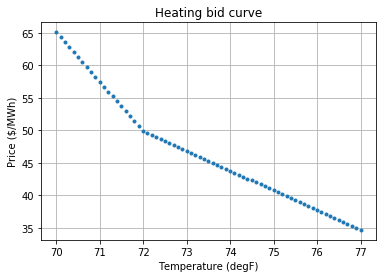

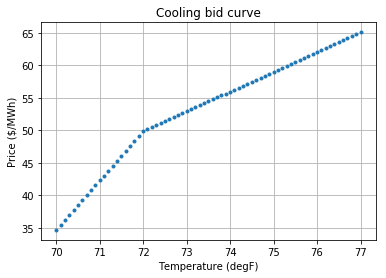

In [15]:
Trange = np.arange(start=Tmin,stop=Tmax+0.05,step=0.1)
Qmode = [10];
Prange = list(map(lambda Tobs:get_hvac_bid(Pexp,Pdev,1,Tobs,Tdes,Tmin,Tmax,Khvac,Qmode)["offer"],Trange))
plot(Trange,Prange,'.')
xlabel('Temperature (degF)')
ylabel('Price ($/MWh)')
title('Heating bid curve')
grid()
show()

Prange = list(map(lambda Tobs:get_hvac_bid(Pexp,Pdev,-1,Tobs,Tdes,Tmin,Tmax,Khvac,Qmode)["offer"],Trange))
plot(Trange,Prange,'.')
xlabel('Temperature (degF)')
ylabel('Price ($/MWh)')
title('Cooling bid curve')
grid()
show()

## HVAC Response

In the absence of forward prices, an HVAC agent computes mode as follows:

$$
    mode = \left\{ \begin{array}{lll}
        mode & : & P_{clear} \le P_{bid}
    \\
        0 & : & P_{clear} \gt P_{bid}.
    \end{array} \right.
$$

Reference: https://www.osti.gov/biblio/926113

**Table 4: HVAC Agent Inputs**

| Variable    | Format | Unit   | Range        | Source      |
| ----------- | ------ | ------ | ------------ | ----------- |
| $P_{bid}$   | +10.4f | \$/MWh | (0,$\infty$( | Market data |
| $P_{clear}$ | +10.4f | \$/MWh | (0,$\infty$( | Market data |

----
# Waterheater

Heat pump waters do not provide temperature readings, so it is not possible to estimate the state-of-charge of the waterheater from the available data.  Consequently, the bidding strategy for the waterheater uses historical data to estimate the expected duty cycle $D_{exp}$. 

## Waterheater Bid

The bid price is computed as follows:

$$
    P_{bid} = P_{exp} + 3 P_{dev} - 6 K_{hw} P_{dev} (1-D_{exp})
$$

where $K_{hw}$ is the savings setting, and 

$$
    D_{exp} = \frac{\frac{t_s}{60}\left(\sum_{t=-1440/t_s}^{-2100/t_s}Q_t\right)-Q_{off}}{Q_{on}-Q_{off}}
$$
is the expected duty cycle, $t_s$ is the market interval (e.g., 5 minutes), $Q_{on}$ is the measured waterheater power when on, $Q_{off}$ is the measured waterheater power when off, and $Q_t$ is the observed waterheater demand at the time $t$.

## Waterheater Response

The waterheater status is computed as follows:
$$
    Q_{set} = \left\{ \begin{array}{lll}
        Q_{bid} & : & P_{clear} \le P_{bid} 
    \\
        0.0 & : & P_{clear} \gt P_{bid}
    \end{array} \right.
$$

## Advanced Controls

If the waterheater is equipped with an API to obtain the temperature $T_{obs}$ at the top of the tank and the desired water temperature $T_{des}$, then the bid strategy is as follows

**Table 5: Waterheater Agent Inputs**

| Variable    | Format | Unit   | Range        | Source
| ----------- | ------ | ------ | ------------ | ------
| $t_s$       | d      | s      | )0,$\infty$( | Market configuration
| $Q_t$       | g      | MWh    | (0,$\infty$( | Device measurements
| $Q_{bid}$   | g      | MWh    | (0,$\infty$( | Market bids
| $P_{bid}$   | +10.4f | \$/MWh | (0,$\infty$( | Market bids
| $P_{clear}$ | +10.4f | \$/MWh | (0,$\infty$( | Market clearing

### Example

The following example illustrates the waterheater bids for a range of expected duty cycles. (Note that a different history is generated for example sample, hence the variations in bids over the sampl

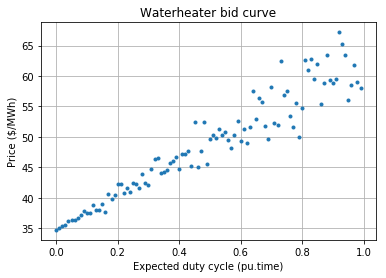

In [13]:
Drange = np.arange(0.0,1.0,0.01)
Prange = list(map(lambda Dexp:get_waterheater_bid(Pexp,Pdev,6,0,1,get_waterheater_history(Dexp=Dexp),5)["offer"],Drange))
plot(Drange,Prange,'.'); 
xlabel('Expected duty cycle (pu.time)'); 
ylabel('Price ($/MWh)')
title('Waterheater bid curve'); 
grid(); 
show()

----
# Photovoltaic

Rooftop PV are price takers. The bid zero and always operate if the price is non-negative.

## PV Bid

PV units bid

$$
    P_{bid} = 0.0
$$

and

$$
    Q_{bid} = Q_{max}
$$

## PV Response

PV units always run

$$
    Q_{set} = \left\{ \begin{array}{lll}
        Q_{max} &:& P_{clear} \ge P_{bid}
    \\
        0.0 &:& P_{clear} \lt P_{bid}
    \end{array} \right. 
$$

where $Q_{set}$ is the power setpoint, and $Q_{bid}$ is the maximum available power.

**Table 6: Photovoltaic Agent Inputs**

| Variable    | Format | Unit   | Range        | Source
| ----------- | ------ | ------ | ------------ | ------
| $Q_{max}$   | g      | MWh    | (0,$\infty$( | Device configuration
| $P_{bid}$   | +10.4f | \$/MWh | (0,$\infty$( | Market bids
| $P_{clear}$ | +10.4f | \$/MWh | (0,$\infty$( | Market clearing

# Battery

The battery bid/response strategy seeks to maintain a user-specified target state-of-charge $E_{des}$. Note that the value of $E_{des}$ may change over time, e.g., according to an occupancy schedule.

## Battery Bid

The buy price is computed as

$$
    P_{bid} = P_{exp} + 3 P_{dev} \frac{E_{obs}-E_{des}}{|E_{ref}-E_{des}|} 
$$

where $E_{obs}$ is the current observed state of charge, and

$$
    E_{ref} = \left\{ \begin{array}{lll}
        E_{min} & : & E_{obs} \le E_{des}
    \\
        E_{max} & : & E_{obs} \gt P_{des},
    \end{array} \right.
$$

with $E_{min}$ and $E_{max}$ as the minimum and maximum allowed state of charge, as specified by the user, but not to go outside the range $[0,E_{cap}]$, where $E_{cap}$ is the storage capacity of the battery.

The sell price is computed as

$$
    TODO
$$

## Battery Response

The price response of the battery is

$$
    Q_{set} = \left\{ \begin{array}{lll}
        -Q_{max} & : & P_{clear} \ge P_{bid}
    \\
        0.0 & : & P_{clear} \lt P_{bid}
    \end{array} \right. 
$$
where

$$
    T_{ref} = \left\{ \begin{array}{lll}
        T_{min} & : & P \le P_{exp}
    \\
        T_{max} & : & P \gt P_{exp},
    \end{array} \right.
$$

**Table 7: Battery Agent Inputs**

| Variable    | Format | Unit   | Range        | Source
| ----------- | ------ | ------ | ------------ | ------
| TODO

Reference: https://ieeexplore.ieee.org/abstract/document/7427483

# EV Charger

EV chargers act like batteries except that they do not bid to sell at any price. In addition, the bid strategy for buying has a target time at which the desired battery charge is to be achieved.

## EV Bid

The EV charger bid is given by

$$
    P_{bid} = P_{exp} + K_{ev} P_{dev} \frac{t_{req}}{t_{rem}}
$$

where $K_{ev}$ is the user preference for charging strategy, $t_{req}$ is the time required to fully charge the battery, and $t_{rem}$ is the time remaining before the battery should be fully charged.

The higher the value the $K_{ev}$ the more likely the battery will be fully charged when the time $t_{rem}$ has elapsed.  

The time required to fully charge the battery is given by

$$
    t_{req} = \frac{E_{max}-E_{des}}{Q_{max}}
$$

where $E_{des}$ is the desired charge added to the battery (in kWh), $E_{max}$ is the maximum capacity of the battery (in kWh), and $Q_{max}$ is the maximum charge rate (in kW).

If the battery $E_{des}$ cannot be measured directly, it must be computed from user input, e.g., as a percent of maximum charge desired.

The available time is computed as the difference between the desired departure time $t_{dep}$ and the current time $t$

$$
    t_{rem} = t_{dep} - t
$$

The desired departure time is a user input.


# EV Response

The EV response is

$$
    Q_{set} = \left\{ \begin{array}{lll}
        P_{clear} \le P_{bid} & : & Q_{on}
    \\
        P_{clear} \gt P_{bid} & : & Q_{off}
    \end{array} \right.
$$

where $Q_{on}$ is the power when the charger is charging the battery, and $Q_{off}$ is the power when the charger is not charging the battery.

**Table 8: EV Charger Agent Inputs**

| Variable    | Format | Unit   | Range        | Source
| ----------- | ------ | ------ | ------------ | ------
| TODO

Reference: https://ieeexplore.ieee.org/abstract/document/7427483